# Pràctica 1: Resolem un problema de classificació

## Objectius

Els objectius d'aquesta pràctica són:

* Aplicar els coneixements adquirits sobre processament de dades, classificació i validacio creuada.
  
* Ser capaç de comparar diferents models de classificació.

* Ser capac de fer cerca d'hiperparàmetres.

* Entendre i implementar la validació creuada.

* Analitzar detalladament els resultats obtinguts durant l'aprenentatge dels diferents models.

Aquesta pràctica és prèvia al cas kaggle que realitzareu durant la segona part de l'assignatura. En aquesta primera pràctica les preguntes estan definides, però us ha de servir d'aprenentatge a l'hora de saber com estructurar un projecte d'aprenentatge automàtic ja que en el cas kaggle no tindreu les preguntes.

## Base de dades

En aquesta pràctica farem servir la base de dades del titanic. L'atribut que predirem es Survived, el qual ens diu si cada passatger va sobreviure o no.


https://www.kaggle.com/c/titanic/data


## Treball en grup
Aquesta pràctica es treballarà en grups de 2-3 persones. En casos excepcionals i degudament justificats la pràctica es podrà realitzar de forma individual.

## Seguiment i entrega de la pràctica

En la pràctica 1 es presenten diverses tasques per fer una correcta comparativa dels resultats obtinguts per diversos mètodes de classificació en una mateixa base de dades.

En aquesta pràctica es realitzaran sessions de seguiment del treball. Aquestes sessions de treball estan orientades a que els alumnes que vingueu pugueu preguntar i resoldre dubtes sobre les dades, preguntar sobre l'objectiu de cada apartat dels enunciats que no us hagi quedat clar, i preguntar sobre els resultats que esteu obtenint a l'hora d'analitzar les dades. És molt recomanable venir a classe amb el treball fet per tal de poder comentar dubtes.

Pel que fa l'entrega, caldrà entregar per caronte el següent:

1. Memòria en format PDF explicant els resultats trobats sobre la bases de dades. La memòria ha d'utilitzar la plantilla de LaTeX que podeu trobar al Caronte i ha de ser de com a màxim 3 pàgines.
   
2. Notebook amb el respectiu codi de python.

3. (Opcional) Presentació amb els resultats 4 min màxim.

# Descripció de la pràctica

A continuació es mostren tots els continguts que s'evaluaran en la pràctica:

1. EDA (exploratory data analysis) (1 punt):
  * Anàlisi de tamany i tipologia de dades
  * Primera valoració de correlacions
  * Anàlisi atribut target
2. Preprocessing (2 punts):
  * Eliminació de nans
  * Encoding de categòriques
  * Altres (PCA, normalització, ...)
3. Metric selection (1.5 punts):
  * Selecció de la millor mètrica pel problema
  * Visualització de ROC/AUC per model base
4. Model Selection amb Crossvalidation (4 punts):
  * Selecció del millor model
  * Cerca d'hiperparàmetres
5. Anàlisi final (1.5 punt)

La pràctica esta construida a partir d'un seguit de preguntes orientatives en cada apartat les quals tenen relació amb els continguts evaluables. **NO cal contestar-les totes**. Són una guia per a que reflexioneu i aprengueu detalls de cada apartat. És recomanable llegir totes les preguntes abans de realitzar la pràctica i tenir-les en ment a l'hora d'executar-la.


**IMPORTANT**: El que es valorarà en la pràctica és la capacitat de mantenir una narrativa coherent alhora que s'expliquen els resultats. No es mirarà tant que alguna pregunta quedi per respondre sinó que els passos seguits en base als resultats obtinguts siguin coherents.

### 1. EDA (exploratory data analysis) (1 punt)

Abans de res cal sempre veure com es la base de dades assignada.

**Preguntes:**
* Quants atributs té la vostra base de dades?
* Quin tipus d'atributs teniu? (Númerics, temporals, categòrics, binaris...)
* Com es el target? quantes categories diferents existeixen?
* Tenim nans en les dades?
* Podeu veure alguna correlació entre X i y?
* Estan balancejades les etiquetes (distribució similar entre categories)? Creieu que pot afectar a la classificació la seva distribució?

In [1]:
import pandas as pd
import numpy as np

# Carregar el dataset
df = pd.read_csv("./titanic/train.csv")

# 1️⃣ Quants atributs té la base de dades?
num_atributs = df.shape[1]
print("Nombre d'atributs:", num_atributs)

# 2️⃣ Tipus d'atributs
tipus_atributs = df.dtypes
print("\nTipus d'atributs:\n", tipus_atributs)

# 3️⃣ Target i categories
target = 'Survived'
categories_target = df[target].nunique()
print("\nTarget:", target)
print("   Nombre de categories:", categories_target)
print("   Categories existents:", df[target].unique())

# 4️⃣ NaNs en les dades
nans = df.isna().sum()
print("\nNombre de NaNs per columna:\n", nans)

# 5️⃣ Correlació entre atributs numèrics i target
# Seleccionar només columnes numèriques
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Correlació només amb numèrics
correlacions = df[num_cols].corr()[target].sort_values(ascending=False)
print("\nCorrelació de cada atribut numèric amb el target:\n", correlacions)

# 6️⃣ Distribució de les etiquetes
distribucio_target = df[target].value_counts(normalize=True)
print("\nDistribució de les etiquetes (proporció):\n", distribucio_target)

# Observació de l'impacte: es pot veure que no està balancejat
if distribucio_target.min() / distribucio_target.max() < 0.5:
    print("   ⚠️ Les etiquetes no estan balancejades, pot afectar la classificació")


Nombre d'atributs: 12

Tipus d'atributs:
 PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Target: Survived
   Nombre de categories: 2
   Categories existents: [0 1]

Nombre de NaNs per columna:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Correlació de cada atribut numèric amb el target:
 Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

Distribució de les etiquetes (proporció):
 Survived
0    0.616162
1  

### 2. Preprocessing (normalitzation, outlier removal, feature selection, ...) (2 punts)
Un cop vistes les dades de les que es disposa, cal preparar les dades per als nostres algoritmes. Segons la tipologia de dades, es poden filtrar atributs, aplicar-hi reductors de dimensionalitat, codificar categories textuals en valors numèrics, normalitzar les dades, treure outliers...

Navegueu per la [documentació de sklearn sobre preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html) per tal de trobar les diferents opcions que proporciona sklearn.

**Preguntes:**
* Estan les dades normalitzades? Caldria fer-ho?
* En cas que les normalitzeu, quin tipus de normalització serà més adient per a les vostres dades?
* Teniu gaires dades sense informació (nans)? Tingueu en compte que hi ha metodes que no els toleren durant l'aprenentatge. Com afecta a la classificació si les filtrem? I si les reompliu? Com ho farieu? [Pista](https://scikit-learn.org/stable/modules/impute.html)
* Teniu dades categòriques? Quina seria la codificació amb més sentit?
* Podreu treure algun atribut extra de les categòriques (per exemple, aplicant alguna regla sobre el text)?
* Caldria aplicar PCA? Quins beneficis o inconvenients trobarieu?
* Caldria aplicar alguna tècnica de selecció de variables? Ho trobeu necessari?

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

#===================================================================================
# APARTAT 2: PREPROCESSING (2 punts)
#===================================================================================
print("\n" + "="*80)
print("APARTAT 2: PREPROCESSING")
print("="*80)

# -------------------------
# 2.1 Anàlisi de NaNs
# -------------------------
print("\n📊 2.1 ANÀLISI DE VALORS FALTANTS")
print("-" * 40)
nan_info = pd.DataFrame({
    'Total_NaN': df.isna().sum(),
    'Percentatge': (df.isna().sum() / len(df) * 100).round(2)
})
print(nan_info[nan_info['Total_NaN'] > 0])

print("\n⚠️  ESTRATÈGIA DE TRACTAMENT DE NaNs:")
print("\n1. Age (19.87% NaNs):")
print("   → Estratègia: KNNImputer amb k=5")
print("   → Justificació: L'edat és una variable crítica per la supervivència.")
print("     KNNImputer utilitza la informació multivariable (Sex, Pclass, Fare, etc.)")
print("     per estimar valors més realistes que una simple mitjana.")
print("     Mantenim la variabilitat natural i les relacions amb altres variables.")

print("\n2. Cabin (77.10% NaNs):")
print("   → Estratègia: Crear variable binària 'Cabin_known' + eliminar columna original")
print("   → Justificació: Massa NaNs per imputar de manera fiable.")
print("     Tenir cabina coneguda pot indicar classe social o proximitat a les sortides.")
print("     La informació binària (té/no té cabina) és més útil que la cabina específica.")

print("\n3. Embarked (0.22% NaNs):")
print("   → Estratègia: SimpleImputer amb strategy='most_frequent'")
print("   → Justificació: Percentatge mínim de NaNs. La moda és suficient i no")
print("     distorsiona la distribució. És eficient i manté la consistència.")

print("\n🔍 ALTERNATIVES CONSIDERADES I DESCARTADES:")
print("\n• SimpleImputer (mean/median/mode):")
print("  ✗ Per Age: No considera relacions amb altres variables (Sex, Pclass, etc.)")
print("  ✓ Per Embarked: Adequat pel baix % de NaNs")

print("\n• IterativeImputer (MICE):")
print("  ✗ Massa computacionalment costós per aquest dataset")
print("  ✗ Risc de sobreajust amb poques dades")
print("  ✗ KNNImputer ja captura relacions multivariables de forma més simple")

print("\n• Eliminar files amb NaNs:")
print("  ✗ Perdríem ~20% del dataset (177 passatgers)")
print("  ✗ Pèrdua significativa d'informació per entrenar el model")

print("\n• MissingIndicator:")
print("  ✗ Redundant: ja creem 'Cabin_known' per capturar aquesta informació")

print("\n✓ CONCLUSIÓ: KNNImputer per Age + Cabin_known + most_frequent per Embarked")

# -------------------------
# 2.2 Feature Engineering
# -------------------------
print("\n🔧 2.2 FEATURE ENGINEERING")
print("-" * 40)

# 2.2.1 Extreure títol del nom
print("\n📌 2.2.1 EXTRACCIÓ DE TÍTOL DEL NOM")
df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
print(f"Títols únics trobats: {df['Title'].nunique()}")
print(f"\nDistribució original de títols:")
print(df['Title'].value_counts())

# Agrupar títols poc freqüents
title_mapping = {
    'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
    'Lady': 'Mrs', 'Countess': 'Mrs', 'Dona': 'Mrs',
    'Capt': 'Officer', 'Col': 'Officer', 'Major': 'Officer',
    'Dr': 'Officer', 'Rev': 'Officer', 'Don': 'Officer',
    'Sir': 'Officer', 'Jonkheer': 'Officer'
}
df['Title'] = df['Title'].replace(title_mapping)

print("\n✓ Títols agrupats:")
print(df['Title'].value_counts())
print("\nLògica d'agrupació:")
print("  • Miss: Dones joves/solteres (Miss, Mlle, Ms)")
print("  • Mrs: Dones casades/classe alta (Mrs, Mme, Lady, Countess, Dona)")
print("  • Officer: Homes amb títols oficials/militars/aristocràtics")
print("  • Mr, Master: Mantinguts per alta freqüència i rellevància")

# 2.2.2 Variable de cabina coneguda
print("\n📌 2.2.2 CREACIÓ DE CABIN_KNOWN")
df['Cabin_known'] = df['Cabin'].notna().astype(int)
print(f"✓ {df['Cabin_known'].sum()} passatgers ({df['Cabin_known'].mean()*100:.2f}%) amb cabina coneguda")
print("   Justificació: Tenir cabina pot correlacionar amb classe social i supervivència")

# 2.2.3 Mida de família
print("\n📌 2.2.3 CREACIÓ DE FAMILY_SIZE")
df['Family_size'] = df['SibSp'] + df['Parch'] + 1
print(f"✓ Rang de Family_size: [{df['Family_size'].min()}, {df['Family_size'].max()}]")
print(f"   Distribució: {df['Family_size'].value_counts().sort_index().to_dict()}")
print("   Justificació: Famílies grans poden tenir més dificultat per evacuar")

# 2.2.4 Viatja sol
print("\n📌 2.2.4 CREACIÓ DE IS_ALONE")
df['Is_alone'] = (df['Family_size'] == 1).astype(int)
print(f"✓ {df['Is_alone'].sum()} passatgers ({df['Is_alone'].mean()*100:.2f}%) viatjant sols")
print("   Justificació: Viatjar sol pot afectar les possibilitats de supervivència")

# 2.2.5 Discussió sobre selecció de features
print("\n📌 2.2.5 SELECCIÓ DE FEATURES - ANÀLISI")
print("\n🔍 ENFOCAMENT: Mantenir totes les variables (excepte les eliminades explícitament)")
print("\nRAONAMENT:")
print("  • En ML no necessitem causalitat, sinó CORRELACIÓ/ASSOCIACIÓ")
print("  • Prioritzem ACCURACY sobre eficiència computacional")
print("  • Sense conèixer la naturalesa exacta de totes les dades, és arriscat eliminar-les")
print("\n✓ Variables mantingudes: Pclass, Sex, Age, SibSp, Parch, Fare, Embarked,")
print("                          Title, Cabin_known, Family_size, Is_alone")
print("\n✗ Variables eliminades: PassengerId (identificador únic sense valor predictiu)")
print("                        Name (informació extreta en 'Title')")
print("                        Ticket (format inconsistent, difícil d'interpretar)")
print("                        Cabin (substituïda per 'Cabin_known')")

print("\n📊 TÈCNIQUES DE SELECCIÓ CONSIDERADES:")
print("\n• Mutual Information: Relació general entre features i target")
print("• Chi-quadrat / Cramér's V: Per variables categòriques")
print("• Point-biserial correlation: Per variables binàries")
print("• Spearman correlation: Per variables ordinals")
print("\n⚠️  NO APLICADES en aquesta fase perquè:")
print("   1. Alguns models (Random Forest, XGBoost) fan selecció implícita")
print("   2. Volem comparar el rendiment amb/sense totes les features")
print("   3. El cost computacional és acceptable amb aquest dataset")

print("\n💡 MILLORA FUTURA:")
print("   Avaluar la importància de cada feature en el model final (feature_importances_)")
print("   i eliminar aquelles amb contribució mínima, comparant l'accuracy resultant.")

# -------------------------
# 2.3 Eliminació de columnes
# -------------------------
print("\n🗑️  2.3 ELIMINACIÓ DE COLUMNES IRRELLEVANTS")
print("-" * 40)
cols_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
print(f"Columnes eliminades: {cols_to_drop}")
print("\nJustificacions:")
print("  • PassengerId: Identificador únic sense valor predictiu")
print("  • Name: Informació extreta en 'Title'")
print("  • Ticket: Format inconsistent i difícil d'interpretar")
print("  • Cabin: Substituïda per 'Cabin_known'")

df_clean = df.drop(columns=cols_to_drop)
print(f"\n✓ Dataset resultant: {df_clean.shape}")

# -------------------------
# 2.4 Separació de features i target
# -------------------------
print("\n🎯 2.4 SEPARACIÓ DE FEATURES I TARGET")
print("-" * 40)
X = df_clean.drop('Survived', axis=1)
y = df_clean['Survived']
print(f"✓ Features (X): {X.shape}")
print(f"✓ Target (y): {y.shape}")
print(f"\n✓ Distribució del target:")
distribucio = y.value_counts(normalize=True)
for classe, percentatge in distribucio.items():
    print(f"   Classe {classe}: {percentatge:.2%}")

# -------------------------
# 2.5 Identificació de tipus de variables
# -------------------------
print("\n📋 2.5 IDENTIFICACIÓ DE TIPUS DE VARIABLES")
print("-" * 40)
numerical_features = ['Age', 'Fare', 'SibSp', 'Parch', 'Family_size']
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title']
binary_features = ['Cabin_known', 'Is_alone']

print(f"\n📊 Variables numèriques ({len(numerical_features)}):")
print(f"   {numerical_features}")
print(f"\n🏷️  Variables categòriques ({len(categorical_features)}):")
print(f"   {categorical_features}")
print(f"\n⚫⚪ Variables binàries ({len(binary_features)}):")
print(f"   {binary_features}")

print("\n💡 ESTRATÈGIA DE CODIFICACIÓ:")
print("  • Numèriques: StandardScaler (després d'imputar NaNs)")
print("  • Categòriques: OneHotEncoder amb drop='first' (evitar multicolinearitat)")
print("  • Binàries: Sense transformació (ja són 0/1)")

# -------------------------
# 2.6 Anàlisi de normalització
# -------------------------
print("\n📐 2.6 ANÀLISI DE NORMALITZACIÓ")
print("-" * 40)
print("\n❓ ESTAN LES DADES NORMALITZADES?")
print("\nEstadístiques ABANS de normalitzar:")
stats_before = X[numerical_features].describe().loc[['mean', 'std', 'min', 'max']]
print(stats_before)

print("\n❌ NO estan normalitzades:")
print(f"   • Age: rang [0.42, 80] amb mean≈{X['Age'].mean():.1f}")
print(f"   • Fare: rang [0, 512] amb mean≈{X['Fare'].mean():.1f}")
print(f"   • Les escales són molt diferents → Afecta models basats en distàncies")

print("\n✅ CALDRIA NORMALITZAR-LES?")
print("\n   SÍ, pels següents motius:")
print("   1. Models sensibles a escales (KNN, SVM, Regressió Logística):")
print("      → Fare (0-512) dominaria sobre Age (0-80) en càlculs de distància")
print("   2. Millora la convergència de gradient descent")
print("   3. Facilita la interpretació de coeficients en models lineals")
print("   4. StandardScaler és robust a outliers moderats")

print("\n🔧 TIPUS DE NORMALITZACIÓ ESCOLLIDA: StandardScaler")
print("\n   Fórmula: z = (x - μ) / σ")
print("   • Transforma a mitjana=0 i std=1")
print("   • Mantén la distribució original")
print("   • No afectat per outliers extrems (a diferència de MinMaxScaler)")
print("\n   Alternatives considerades:")
print("   • MinMaxScaler: ✗ Sensible a outliers (Fare té valors extrems)")
print("   • RobustScaler: ✓ Alternativa vàlida (tractament d'outliers), però StandardScaler és suficient")
print("   • Normalizer: ✗ Normalitza per files, no per columnes (no aplica aquí)")

# -------------------------
# 2.7 Discussió sobre PCA
# -------------------------
print("\n🔬 2.7 CALDRIA APLICAR PCA?")
print("-" * 40)
print("\n❌ NO aplicarem PCA en aquest cas")
print("\nRAONS:")
print("  • Dataset petit (891 passatgers, ~15 features després de OneHot)")
print("  • No hi ha problema de dimensionalitat (regla general: n_samples >> n_features)")
print("  • Pèrdua d'interpretabilitat: no sabríem quines features són importants")
print("  • Les features tenen significat real i volem mantenir-lo")

print("\n✅ BENEFICIS de PCA (si s'apliqués):")
print("  + Reducció de dimensionalitat")
print("  + Eliminació de multicolinearitat")
print("  + Reducció de soroll")
print("  + Millora computacional en datasets grans")

print("\n❌ INCONVENIENTS de PCA:")
print("  - Pèrdua d'interpretabilitat (components principals no tenen significat clar)")
print("  - Assumeix relacions lineals")
print("  - Requereix normalització prèvia")
print("  - Pot eliminar informació rellevant per models no lineals")

print("\n💡 CONCLUSIÓ: Mantenim les features originals per interpretabilitat i")
print("              perquè el dataset no té problemes de dimensionalitat.")

# -------------------------
# 2.8 Pipeline de preprocessing
# -------------------------
print("\n🔄 2.8 CREACIÓ DEL PIPELINE DE PREPROCESSING")
print("-" * 40)

# Pipeline per variables numèriques: KNNImputer + StandardScaler
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

# Pipeline per variables categòriques: SimpleImputer + OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# ColumnTransformer per combinar tots els transformadors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  # Variables binàries sense transformar
)

print("✓ Pipeline creat amb 3 components:")
print("\n  1️⃣  NUMÈRIQUES:")
print("      → KNNImputer(n_neighbors=5): Imputa Age basant-se en 5 veïns més propers")
print("      → StandardScaler(): Normalitza a mean=0, std=1")
print(f"      → Aplica a: {numerical_features}")

print("\n  2️⃣  CATEGÒRIQUES:")
print("      → SimpleImputer(most_frequent): Imputa Embarked amb la moda")
print("      → OneHotEncoder(drop='first'): Evita dummy variable trap")
print(f"      → Aplica a: {categorical_features}")

print("\n  3️⃣  BINÀRIES:")
print("      → Passthrough: No es transformen (ja són 0/1)")
print(f"      → Aplica a: {binary_features}")

# -------------------------
# 2.9 Split i aplicació del preprocessing
# -------------------------
print("\n⚙️  2.9 TRAIN/TEST SPLIT I APLICACIÓ DEL PREPROCESSING")
print("-" * 40)

# Split ABANS del preprocessing per evitar data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y
)

print(f"✓ Train set: {X_train.shape} ({len(X_train)/len(X)*100:.1f}%)")
print(f"✓ Test set:  {X_test.shape} ({len(X_test)/len(X)*100:.1f}%)")

print("\n✓ Distribució mantinguda (stratify=y):")
dist_train = y_train.value_counts(normalize=True)
dist_test = y_test.value_counts(normalize=True)
for classe in [0, 1]:
    print(f"   Classe {classe}: Train={dist_train[classe]:.2%}, Test={dist_test[classe]:.2%}")

# Aplicar preprocessing
print("\n🔧 Aplicant preprocessing...")
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

print(f"\n✓ Dades preprocessades:")
print(f"   Train shape: {X_train_preprocessed.shape}")
print(f"   Test shape:  {X_test_preprocessed.shape}")
print(f"   Total features: {X_train_preprocessed.shape[1]}")

# Verificar normalització
n_numeric = len(numerical_features)
sample_numeric = X_train_preprocessed[:, :n_numeric]
print(f"\n✅ VERIFICACIÓ DE NORMALITZACIÓ (primeres {n_numeric} columnes numèriques):")
print(f"   Mitjana:     {sample_numeric.mean():.6f} (esperat: ≈0)")
print(f"   Desv. std:   {sample_numeric.std():.6f} (esperat: ≈1)")
print(f"   Min:         {sample_numeric.min():.2f}")
print(f"   Max:         {sample_numeric.max():.2f}")

if abs(sample_numeric.mean()) < 0.01 and abs(sample_numeric.std() - 1) < 0.1:
    print("\n   ✓ Normalització correcta!")
else:
    print("\n   ⚠️  Possible problema amb la normalització")

# -------------------------
# 2.10 Resum final
# -------------------------
print("\n" + "="*80)
print("📝 RESUM DEL PREPROCESSING")
print("="*80)
print("\n✅ DECISIONS PRESES:")
print("   1. NaNs tractats amb KNNImputer (Age) i most_frequent (Embarked)")
print("   2. Feature engineering: Title, Cabin_known, Family_size, Is_alone")
print("   3. Normalització amb StandardScaler per variables numèriques")
print("   4. OneHotEncoder per variables categòriques")
print("   5. No s'aplica PCA (dataset petit, volem interpretabilitat)")
print("   6. Mantenim totes les features rellevants (no fem selecció agressiva)")
print("\n✅ DATASET FINAL:")
print(f"   Samples: {len(X_train)} train + {len(X_test)} test = {len(X)} total")
print(f"   Features: {X_train_preprocessed.shape[1]} (després del preprocessing)")
print(f"   NaNs: 0 (tots imputats)")
print(f"   Normalitzat: Sí (variables numèriques)")
print(f"   Codificat: Sí (variables categòriques)")
print("\n✅ READY FOR MODEL TRAINING! 🚀")
print("="*80)


APARTAT 2: PREPROCESSING

📊 2.1 ANÀLISI DE VALORS FALTANTS
----------------------------------------
          Total_NaN  Percentatge
Age             177        19.87
Cabin           687        77.10
Embarked          2         0.22

⚠️  ESTRATÈGIA DE TRACTAMENT DE NaNs:

1. Age (19.87% NaNs):
   → Estratègia: KNNImputer amb k=5
   → Justificació: L'edat és una variable crítica per la supervivència.
     KNNImputer utilitza la informació multivariable (Sex, Pclass, Fare, etc.)
     per estimar valors més realistes que una simple mitjana.
     Mantenim la variabilitat natural i les relacions amb altres variables.

2. Cabin (77.10% NaNs):
   → Estratègia: Crear variable binària 'Cabin_known' + eliminar columna original
   → Justificació: Massa NaNs per imputar de manera fiable.
     Tenir cabina coneguda pot indicar classe social o proximitat a les sortides.
     La informació binària (té/no té cabina) és més útil que la cabina específica.

3. Embarked (0.22% NaNs):
   → Estratègia: Simp

### 3. Metric selection (1.5 punts)
En aquest apartat ens centrarem en les mètriques de classificació ([documentació](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)). Per a fer-ho, entreneu una regressio logistica i a partir d'aquesta generarem una serie de funcions per analitzar els nostres resultats. Aquestes funcions ens serviran més endavant. Caldrà tambe triar la mètrica que farem servir després per triar el millor model.

**Preguntes:**
* A teoria, hem vist el resultat d'aplicar el `accuracy_score` sobre dades no balancejades. Podrieu explicar i justificar quina de les següents mètriques será la més adient pel vostre problema? `accuracy_score`, `f1_score` o `average_precision_score`?
* Abans de començar a entrenar models, genereu una suite de funcions per poder analitzar graficament com esta anant el vostre model. Mostreu la Precisió-Recall Curve i la ROC Curve. Quina és més rellevant pel vostre dataset?
* Què mostra [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)? Quina mètrica us fixareu per tal de optimitzar-ne la classificació pel vostre cas?

**Nota**: Fixeu-vos que en aquest apartat NO ES VALOREN ELS RESULTATS. L'únic que es valora és l'elecció de la mètrica de classificació així com saber quin tipus de gràfiques fer per analitzar els resultats. Abans de solucionar un problema cal tenir molt clar la mètrica d'error que es farà servir, i és una decisió que cal pendre de forma prèvia a entrenar models.

In [ ]:
'''
Accuracy: Percentatge de prediccions correctes sobre el total.
Precision: Proporció de prediccions positives que són realment positives (TP / (TP + FP)).
Recall (True Positive Rate, TPR): Proporció de positius reals que el model detecta respecte la realitat de positius (TP / (TP + FN)).
F1-score: Mitjana harmònica entre precision i recall (equilibri).
Precision-Recall Curve: Gràfic que mostra com canvien precision i recall segons el llindar.
- Eixos: X = Recall, Y = Precision
- Mostra trade-off entre detectar positius i evitar falsos positius.
- Cada punt = un llindar diferent.
- Molt útil amb classes desequilibrades.
- Àrea sota corba = Average Precision (AP)
ROC Curve: Gràfic de True Positive Rate (Recall) vs False Positive Rate a diferents llindars, per cada llindar, es calcula TPR i FPR.
- Eixos: X = FPR (False Positive Rate), Y = TPR (Recall)
- Mostra com canvia TPR respecte a FPR segons el llindar.
- Cada punt = un llindar diferent.
- Útil amb classes equilibrades.
- Àrea sota corba = ROC-AUC (mesura la capacitat de separar positives i negatives).
Threshold en la gràfica: Valor de decisió per classificar una mostra com positiva si la probabilitat estimada és superior
  o igual a aquest llindar, així havent-hi a la gràfica tants punts com thresholds. Per tant, si tinguéssim una mica menys
  de probablitiat, per aquell threshold, la mostra es classificaria com negativa. I fixat si fixéssim el threshold una mica
  menor, obtindríem un punt diferent a la gràfica associat a aquest nou threshold.
'''

In [5]:
# Entrenament de regressió logística com a exemple
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, average_precision_score,
    precision_recall_curve, roc_curve, auc,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# Entrenar model base
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_preprocessed, y_train)

# Prediccions
y_pred = lr_model.predict(X_test_preprocessed)
y_pred_proba = lr_model.predict_proba(X_test_preprocessed)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
avg_precision = average_precision_score(y_test, y_pred_proba)

print(f"\nResultats amb el model base:")
print(f"   • Accuracy Score:          {accuracy:.4f}")
print(f"   • F1 Score:                {f1:.4f}")
print(f"   • Average Precision Score: {avg_precision:.4f}")



Resultats amb el model base:
   • Accuracy Score:          0.8156
   • F1 Score:                0.7556
   • Average Precision Score: 0.8351


In [ ]:
# Amb el model entrenat, podem avaluar les mètriques en qüestió, però 
# no podem escollir quines mètriques són més adequades sense conèixer
# la distribució de les classes en el dataset, i què es vol prioritzar.

In [4]:
class_distribution = y.value_counts(normalize=True)
majority_class = class_distribution.max()
minority_class = class_distribution.min()
imbalance_ratio = majority_class / minority_class

print(f"Distribució de classes:")
print(f"   Classe 0 (No sobreviu): {class_distribution[0]:.2%}")
print(f"   Classe 1 (Sobreviu):    {class_distribution[1]:.2%}")
print(f"\nRàtio de desequilibri: {imbalance_ratio:.2f}:1")

Distribució de classes:
   Classe 0 (No sobreviu): 61.62%
   Classe 1 (Sobreviu):    38.38%

Ràtio de desequilibri: 1.61:1


In [ ]:
# Amb un ràtio de 1.61:1, el dataset NO està severament desequilibrat,
# però SÍ té un biaix cap a la classe majoritària (No sobreviu, 0).
# Això afectarà la selecció de mètriques de la següent manera:

# 1. Accuracy: Pot ser enganyosa en datasets desequilibrats.
#    Al Titanic, encara que no és extremadament desequilibrat, hi ha més morts que supervivents.
#    Així que un model que prediu gairebé sempre "mor" tindria bona accuracy,
#    però seria inútil per detectar els supervivents. Per això no l'hem triada.

# 2. Precision i Recall: Són més informatives per avaluar el rendiment
#    en la classe minoritària ("Sobreviu", 1).  
#    - Precision mira quants dels supervivents predits realment sobreviuen (minimitzar falsos positius).
#    - Recall mira quants dels supervivents reals hem detectat (minimitzar falsos negatius).
#    Per comparar models cal un equilibri entre ambdues, així que tampoc les hem triades soles.

# 3. Average Precision Score: Resumeix tota la Precision-Recall curve.
#    És més útil quan el model retorna probabilitats i hi ha molts casos positius escassos.
#    En aquest cas, com les classes no són extremadament desequilibrades i volem un valor senzill
#    per comparar models, no l’hem triada.

# 4. ROC-AUC ((X,Y)=(FPR,TPR)): També resumeix la capacitat del model per separar classes.
#    Però és menys informativa que la Precision-Recall curve en casos desequilibrats,
#    ja que pot donar una falsa sensació de bon rendiment quan hi ha molts negatius, ja que
#    el FPR = FP / FP + TN pot ser baix simplement perquè hi ha molts negatius i per tant, TN.

# 5. F1-score: Combina Precision i Recall en una mitjana harmònica,
#    equilibrant la capacitat de detectar supervivents (recall) i no predir falsament supervivents (precision).
#    Per això, hem triat l'F1-score com a mètrica principal per avaluar els models.

# Sabent això, generem la suite de funcions per visualització a continuació.



In [ ]:
def plot_precision_recall_curve(y_true, y_pred_proba, model_name="Model"):
    """
    Genera la Precision-Recall Curve.
    
    Aquesta corba mostra el trade-off entre Precision i Recall
    per diferents thresholds de classificació.
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    ap_score = average_precision_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label=f'{model_name} (AP={ap_score:.3f})')
    plt.xlabel('Recall (Sensibilitat)', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt.gcf()

def plot_roc_curve(y_true, y_pred_proba, model_name="Model"):
    """
    Genera la ROC Curve (Receiver Operating Characteristic).
    
    Aquesta corba mostra el trade-off entre True Positive Rate (TPR)
    i False Positive Rate (FPR) per diferents thresholds.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, marker='.', label=f'{model_name} (AUC={roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.5)')
    plt.xlabel('False Positive Rate (1 - Specificitat)', fontsize=12)
    plt.ylabel('True Positive Rate (Recall)', fontsize=12)
    plt.title('ROC Curve', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt.gcf()

def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    """
    Genera la matriu de confusió.
    
    Mostra visualment els True Positives, True Negatives,
    False Positives i False Negatives.
    """
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Sobreviu', 'Sobreviu'])
    
    fig, ax = plt.subplots(figsize=(7, 6))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f'Matriu de Confusió - {model_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

def print_classification_metrics(y_true, y_pred, y_pred_proba):
    """
    Imprimeix un resum complet de mètriques de classificació.
    """
    # Mètriques globals
    print("\n🎯 Mètriques globals:")
    print(f"   • Accuracy:          {accuracy_score(y_true, y_pred):.4f}")
    print(f"   • F1 Score:          {f1_score(y_true, y_pred):.4f}")
    print(f"   • Average Precision: {average_precision_score(y_true, y_pred_proba):.4f}")
    print(f"   • ROC AUC:           {auc(*roc_curve(y_true, y_pred_proba)[:2]):.4f}")
    
    # Classification report
    print("\n📋 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['No Sobreviu', 'Sobreviu']))

In [ ]:
# Amb aquest codi podem generar les gràfiques i mètriques per avaluar el model entrenat.

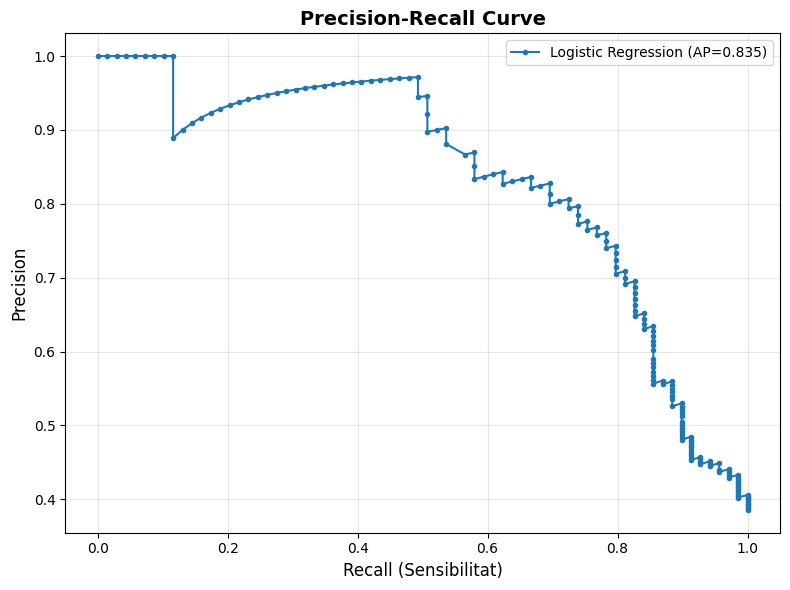

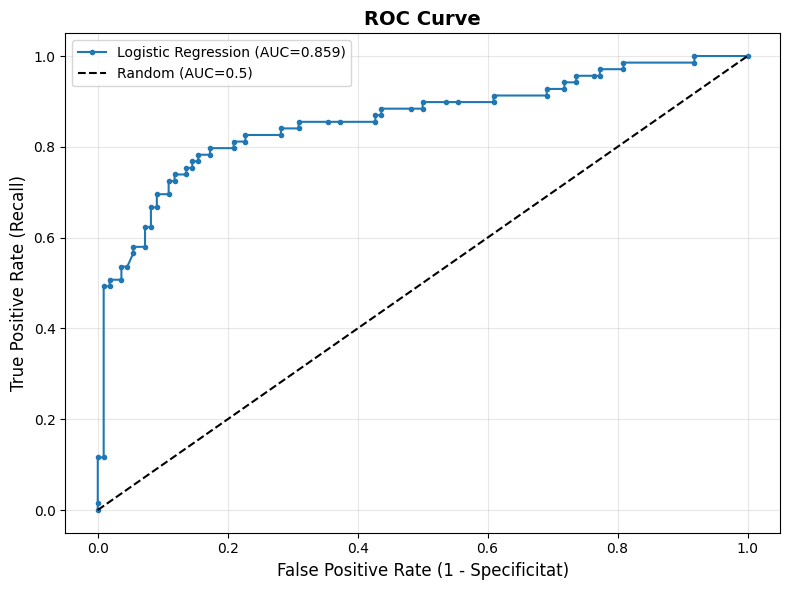

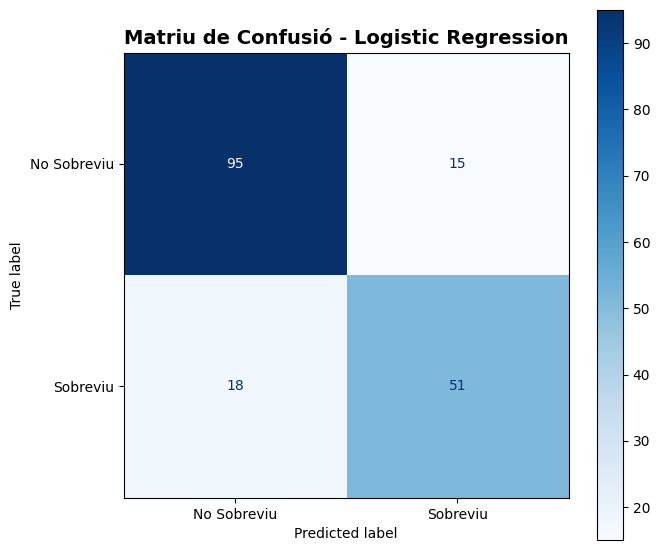


📊 RESUM DE MÈTRIQUES

🎯 Mètriques globals:
   • Accuracy:          0.8156
   • F1 Score:          0.7556
   • Average Precision: 0.8351
   • ROC AUC:           0.8592

📋 Classification Report:
              precision    recall  f1-score   support

 No Sobreviu       0.84      0.86      0.85       110
    Sobreviu       0.77      0.74      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179

🔢 Matriu de Confusió:
   TN= 95  FP= 15
   FN= 18  TP= 51


In [6]:
fig_pr = plot_precision_recall_curve(y_test, y_pred_proba, "Logistic Regression")
plt.show()

fig_roc = plot_roc_curve(y_test, y_pred_proba, "Logistic Regression")
plt.show()

fig_cm = plot_confusion_matrix(y_test, y_pred, "Logistic Regression")
plt.show()

# Mètriques detallades
print_classification_metrics(y_test, y_pred, y_pred_proba)

In [ ]:
# El classification_report mostra diverses mètriques per cada classe i globalment:
# - Precision: de totes les prediccions positives, quantes són correctes.
#   Exemple: Sobreviu precision = 0.77 → del total de prediccions “Sobreviu”, el 77% són correctes.
# - Recall (sensibilitat): de tots els positius reals, quants detectem.
#   Exemple: Sobreviu recall = 0.74 → detectem el 74% dels supervivents reals.
# - F1-score: mitjana harmònica de precision i recall, equilibra detectar positius sense generar massa falsos positius.
#   Exemple: Sobreviu F1 = 0.76 → resumeix el rendiment sobre aquesta classe minoritària.
# - Support: nombre de mostres reals d’aquesta classe. Exemple: 69 supervivents.
# - Accuracy: proporció total de prediccions correctes (0.82).
# - Macro avg: mitjana simple de les mètriques per classe.
# - Weighted avg: mitjana ponderada pel nombre de mostres de cada classe.

# En termes pràctics i morals, ens interessa prioritzar el recall de la classe positiva (Sobreviu),
# ja que volem minimitzar falsos negatius i no deixar fora persones que realment sobreviuen.
# És a dir, optem per prioritzar en detectar tots els supervivents i ajustem el threshold si cal (baixant-lo,
# acceptant alguns FP per maximitzar la seguretat moral del nostre model abans que trobar-nos més FN.


# Per optimitzar la classificació del nostre cas, ens fixem especialment en:
# - Recall de la classe positiva → captar la majoria de supervivents.
# - Average Precision / F1-score → equilibrar que no hi hagi massa falsos positius.

### 4. Model Selection amb validació creuada (4 punts)

Fent servir la mètrica trobada en l'apartat anterior, en aquest apartat caldrà seleccionar una sèrie de models i, fent ús de la validació creuada, seleccionar el millor model amb els seus respectius millors hyperpàrametres que haurem buscat fent hyperparameter search.

La tasca d'aquesta pràctica s'enmarca dins l'aprenentatge computacional **supervisat**. A sklearn, disposem de diverses tècniques [(veure documentació)](https://scikit-learn.org/stable/supervised_learning.html). A les classes de teoria, hem vist tècniques com ara logistic regression, SVM amb diferents kernels, Nearest Neighbour... i també coneixeu altres tecniques d'altres cursos, com els arbres de decisio. Per aquest apartat es demana seleccionar **un minim de 3 models**.

**Preguntes:**
* Quins models heu considerat? Per què els heu seleccionat?
* Fent servir validació creuada, escolliu el millor model (agafant els hiperparàmetres per defecte). Recordeu fer servir la mètrica utilitzada en l'apartat anterior i fer fer servir algun [tipus de validacio creuada](https://scikit-learn.org/stable/modules/cross_validation.html).

* Seleccioneu una sèrie d'hiperparàmetres a provar per cadascun dels models i realitzeu una cerca d'hiperparàmetres. Hi ha algun model que creieu que podeu descartar de primeres? Per què?

* Mostreu els resultats en una taula on es mostri el model, els experiments realitzats i els resultats obtinguts (tant en train com en test). Podeu mostrar tambe el temps d'entrenament de cada model.

* Quin tipus de validació heu escollit en la selecció de models?

* Quines formes de buscar els millors hiperparàmetres heu trobat? Són costoses computacionalment parlant? [documentació](https://scikit-learn.org/stable/modules/grid_search.html). Quina heu seleccionat?

* Si disposem de recursos limitats (per exemple, un PC durant 1 hora), quin dels mètodes creieu que obtindrà millor resultat final?

* Opcional: Feu la prova, i amb el model i el metode de validació creuada escollit, configureu els diferents mètodes de cerca per a que s'executin durant el mateix temps (i.e. depenent del problema, 0,5h-1 hora). Analitzeu quin ha arribat a una millor solució. (Ajuda: estimeu el temps que trigarà a fer 1 training el vostre model, i així trobeu el número de intents que podeu fer en cada cas.)

### 5.Anàlisi Final (1.5 punt)

Un cop seleccionat el millor model amb els millors hiperparàmetres, caldrà fer un anàlisi final amb els resultats obtinguts.

**Preguntes:**
* Mostreu les corves ROC/PR (la que hagueu escollit en l'apartat 2) i interpreteu els resultats.

* Analitzeu en detall les diferents mètriques que trobeu adients i comenteu per sobre com podrieu fer servir aquest model en un futur. Això és el que es coneix com un cas d'ús.

* Com creieu que es podria millorar el vostre model?